# Лабораторная работа №6
## Выполнил Буканов Никита ПМ-21М
## Вариант 2

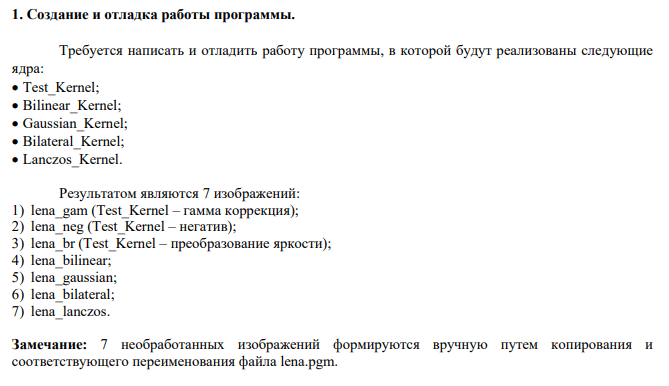

```c++
#include <cuda.h>
#include <cuda_runtime.h>
#include "helper_image.h"

typedef unsigned int uint;
typedef unsigned char uchar;
texture<uchar, cudaTextureType2D, cudaReadModeElementType> g_Texture;
uint WIDTH = 512;
uint HEIGHT = 512;
```

## Тут разделил 1 функцию на 3
```c++
__global__ void Test_KernelNeg(uchar *pDst, float g, uint w, uint h)
{
  size_t tidx = threadIdx.x + blockIdx.x * blockDim.x;
  size_t tidy = threadIdx.y + blockIdx.y * blockDim.y;
  
  if (tidx < w && tidy < h)
  {
    float c = tex2D<uchar>(g_Texture, tidx + 0.5f, tidy + 0.5f);;
    float r = 1.0f - c;
    pDst[tidx + tidy *w] = (int)r;
  }
}

__global__ void Test_KernelGamma(uchar *pDst, float g, uint w, uint h)
{
  size_t tidx = threadIdx.x + blockIdx.x * blockDim.x;
  size_t tidy = threadIdx.y + blockIdx.y * blockDim.y;
  
  if (tidx < w && tidy < h)
  {
    float c = tex2D<uchar>(g_Texture, tidx + 0.5f, tidy + 0.5f);
    float r = powf(c, g);
    pDst[tidx + tidy *w] = (int)r;
  }
 
}

__global__ void Test_KernelBrightness(uchar *pDst, float g, uint w, uint h)
{
  size_t tidx = threadIdx.x + blockIdx.x * blockDim.x;
  size_t tidy = threadIdx.y + blockIdx.y * blockDim.y;
  
  if (tidx < w && tidy < h)
  {
    float c = tex2D<uchar>(g_Texture, tidx + 0.5f, tidy + 0.5f);
    float r = c * 0.3f;
    pDst[tidx + tidy *w] = (int)r;
  }
}
```

## В этом блоке изменений нет
```c++
__global__ void Gaussian_Kernel(unsigned char * pDst, float radius, float sigma_sq, int w,
                                int h)
{
  int tidx = threadIdx.x + blockIdx.x * blockDim.x;
  int tidy = threadIdx.y + blockIdx.y * blockDim.y;
  
  if (tidx < w && tidy < h)
  {
    float r = 0;
    float weight_sum = 0.0f;
    float weight = 0.0f;
    for (int ic = -radius; ic <= radius; ic++)
    {
      weight = exp(-(ic*ic) / sigma_sq);
      r += tex2D<uchar>(g_Texture, tidx + 0.5f + ic, tidy + 0.5f)* weight;
      weight_sum += weight;
    }
    r /= weight_sum;
    pDst[tidx + tidy*w] = (int)r;
  }
}

__global__ void Bilinear_Kernel(unsigned char * dest, float factor, unsigned int w,
                                unsigned int h)
{
  size_t tidx = threadIdx.x + blockIdx.x * blockDim.x;
  size_t tidy = threadIdx.y + blockIdx.y * blockDim.y;
  // проверка, что текущие индексы не выходят за границы изображения
    
  if (tidx < w && tidy < h) {
    float center = tidx / factor;
    auto start = (unsigned int)center;
    unsigned int stop = start + 1.0f;
    float t = center - start;
    unsigned char a = tex2D<uchar>(g_Texture, tidy + 0.5f, start + 0.5f);
    unsigned char b = tex2D<uchar>(g_Texture, tidy + 0.5f, stop + 0.5f);
    float linear = (b - a)*t + a;
    dest[tidx + tidy*w] = (int)(linear);
  }
}

// Функции для загрузки и сохранения изображения
void loadImage(char *file,
               unsigned char** pixels,
               unsigned int* width,
               unsigned int* height) {
  size_t file_length = strlen(file);
    
  if (!strcmp(&file[file_length - 3], "pgm"))
  {
    if (!sdkLoadPGM<unsigned char>(file, pixels, width, height))
    {
      printf("Failed to load PGM image file: %s\n", file);
      exit(EXIT_FAILURE);
    }
  }
}
void saveImage(char *file, unsigned char* pixels, unsigned int width, unsigned int height)
{
  size_t file_length = strlen(file);
    
  if (!strcmp(&file[file_length - 3], "pgm"))
  {
    sdkSavePGM(file, pixels, width, height);
  }
}

__device__ float Lanczos(float x, float r)
{
  const float m_pi = 3.14159265f;
  float result = 0.0f;
    
  if (x >= -r && x <= r) {
    float a = x*m_pi;
    float b = (r*(sin(a / r)) * (sin(a)) / (a*a));
    result = (x == 0.0f) ? 1.0f : b;
  }
  return result;
}
__global__ void Lanczos_Kernel(uchar * pDst, float factor, float blur, float radius, float
support, float scale, uint w, uint h)
{
  size_t tidx = threadIdx.x + blockIdx.x * blockDim.x;
  size_t tidy = threadIdx.y + blockIdx.y * blockDim.y;
  // проверка, что текущие индексы не выходят за границы изображения
    
  if (tidx < w && tidy < h)
  {
    float r = 0;
    float weight_sum = 0.0f, weight = 0.0f;
    float center = tidx / factor;
      
    uint start = (uint)fmax(center - support + 0.5f, (float)0);
    uint stop = (uint)fmin(center + support + 0.5f, (float)w);
      
    float nmax = stop - start;
    float s = start - center;
      
    for (size_t n = 0; n < nmax; ++n, ++s) {
      weight = Lanczos(s*scale, radius);
      weight_sum += weight;
      r += (tex2D<uchar>(g_Texture, tidy + 0.5f, start + n + 0.5f)* weight);
    }
    if (weight_sum != 0.0f)
    {
      //нормализация полученных результатов
      r /= weight_sum;
    }
    pDst[tidx + tidy*w] = int(r);
  }
}

```


## Внесены исправления
```c++
__global__ void Bilateral_Kernel(uchar * pDst, int radius, float sigma,
                                 float weight_threshold, uint w, uint h)
{
  int area = (2 * radius + 1) * (2 * radius + 1);
  int tidx = threadIdx.x + blockIdx.x * blockDim.x;
  int tidy = threadIdx.y + blockIdx.y * blockDim.y;
    
  if (tidx < w && tidy < h)
  {
    float r = 0;
    float weight_sum = 0.0f;
    float weight = 0.0f;
    float weight_threshold_counter = 0.0f;
    float c00 = tex2D<uchar>(g_Texture, tidx + 0.5f, tidy + 0.5f);

    for (int ir = -radius; ir <= radius; ir++)
    {
      for (int ic = -radius; ic <= radius; ic++)
      {

        float c = tex2D<uchar>(g_Texture, tidx + 0.5f + ic, tidy + 0.5f + ir);
        uint param = 0; // !!! ПОПРОБУЙТЕ ИЗМЕНЯТЬ ДАННЫЙ ПАРАМЕТР

        float v1 = expf(-abs(ir * ir + ic * ic) / (2 * radius * radius));
        float v2 = expf(-abs(c - c00) *abs(c - c00) / (2 * sigma * sigma));
          
        assert(v1 < 1.01 && v2 < 1.01);
          
        weight = v1 * v2;
        weight_sum += weight;
        weight_threshold_counter += (weight >= weight_threshold ? 1.0f : 0.0f);
        r += (c * weight);
          
      }
    }

    r /= weight_sum;
    r = c00 + (r - c00) * weight_threshold_counter / area;
    pDst[tidx + tidy * w] = (int)r;
  }
}
```

```c++
int main(int argc, char ** argv)
{
  unsigned char* d_result_pixels;
  unsigned char* h_pixels = nullptr;
  unsigned char* d_pixels = nullptr;
  char* src_path = "/home/nkt/work/gpu_labs/lab6/lena.pgm"; 
  size_t image_size = sizeof(unsigned char) * WIDTH * HEIGHT;
  auto* h_result_pixels = (unsigned char *)malloc(image_size);
   
  loadImage(src_path, &h_pixels, &WIDTH, &HEIGHT);
  cudaMalloc((void **)& d_pixels, image_size);
  cudaMalloc((void **)& d_result_pixels, image_size);
  cudaMemcpy(d_pixels, h_pixels, image_size, cudaMemcpyHostToDevice);
    
  int n = 8; 
  dim3 block(n, n);
  dim3 grid(WIDTH / n, HEIGHT / n);
  cudaChannelFormatDesc desc = cudaCreateChannelDesc<uchar1>();
  size_t offset = 0;
    
  cudaError_t error = cudaBindTexture2D(0, &g_Texture, d_pixels, &desc, WIDTH, HEIGHT,
                                        WIDTH * sizeof(unsigned char));
  if (cudaSuccess != error)
  {
    printf("ERROR: Failed to bind texture.\n");
    exit(-1);
  }
  else
  {
    printf("Texture was successfully binded\n");
  }


  Test_KernelGamma<<< grid, block >>> (d_result_pixels, 1.2, WIDTH, HEIGHT);
  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  char* d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_gamma.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  cudaEvent_t start_1, stop_1;
  float gpuTime;
  cudaEventCreate (&start_1);
  cudaEventCreate (&stop_1);
  cudaEventRecord (start_1, 0);

  Test_KernelNeg <<< grid, block >>> (d_result_pixels, 1.2, WIDTH, HEIGHT);

  cudaEventRecord(stop_1, 0);
  cudaEventSynchronize(stop_1);
  cudaEventElapsedTime(&gpuTime, start_1, stop_1);
  std::cout << "Negative GPU elapsed time: " << gpuTime << std::endl;


  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_neg.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  Test_KernelBrightness<<< grid, block >>> (d_result_pixels, 1.2, WIDTH, HEIGHT);
  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_brightness.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  Bilinear_Kernel<<<grid, block>>>(d_result_pixels, 1.2, WIDTH, HEIGHT);
  Bilinear_Kernel<<<grid, block>>>(d_result_pixels, 4, WIDTH, HEIGHT);
  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_bilinear.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);


  Gaussian_Kernel <<<grid, block>>> (d_result_pixels, 1, 1, WIDTH, HEIGHT);
  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_gauss.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  cudaEvent_t start, stop;
  gpuTime = 0.0f;
  cudaEventCreate (&start);
  cudaEventCreate (&stop);
  cudaEventRecord (start, 0);
  Bilateral_Kernel<<<grid, block>>>(d_result_pixels, 3, 200, 0, WIDTH, HEIGHT);
  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  cudaEventElapsedTime(&gpuTime, start, stop);
  std::cout << "Bilateral GPU elapsed time: " << gpuTime << std::endl;

  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_bilateral.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  Lanczos_Kernel<<<grid, block>>> (d_result_pixels, 1.1, 4, 10, 2, 2, WIDTH, HEIGHT);
  cudaMemcpy(h_result_pixels, d_result_pixels, image_size, cudaMemcpyDeviceToHost);
  d_result_path = "/home/nkt/work/gpu_labs/lab6/lena_lancroz.pgm";
  saveImage(d_result_path, h_result_pixels, WIDTH, HEIGHT);

  // отвязка текстуры
  cudaUnbindTexture(&g_Texture);
}


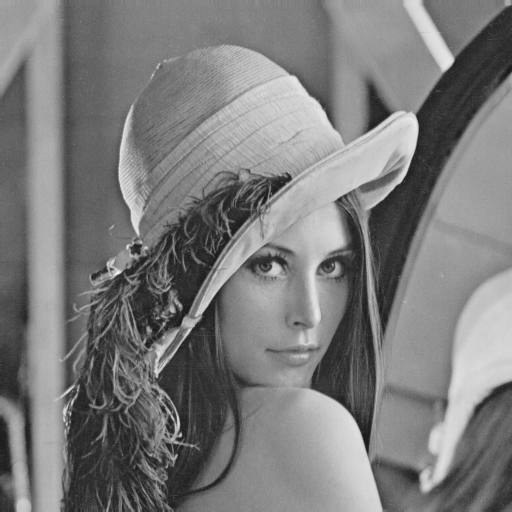

In [26]:
I.open('lena.pgm')

## Гамма фильтр

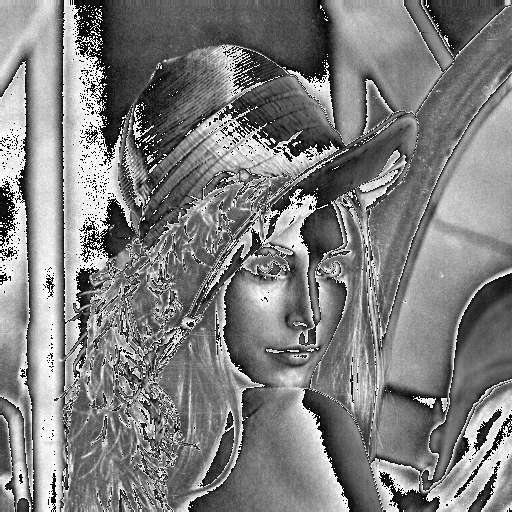

In [27]:
I.open('lena_gamma.pgm')

## Негатив

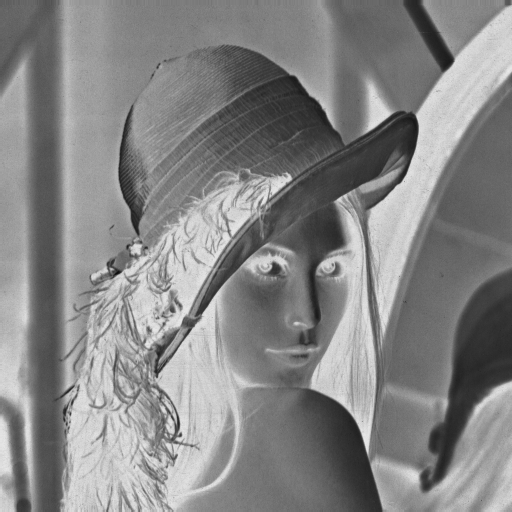

In [28]:
I.open('lena_neg.pgm')

## Яркость

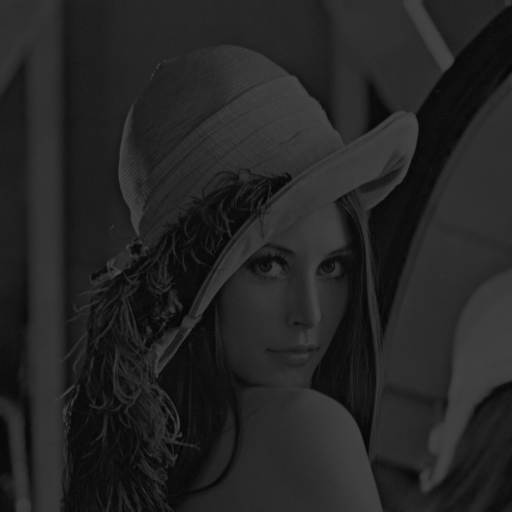

In [29]:
I.open('lena_brightness.pgm')

## Билинейный фильтр c разными параметрами
Factor = 1.2 

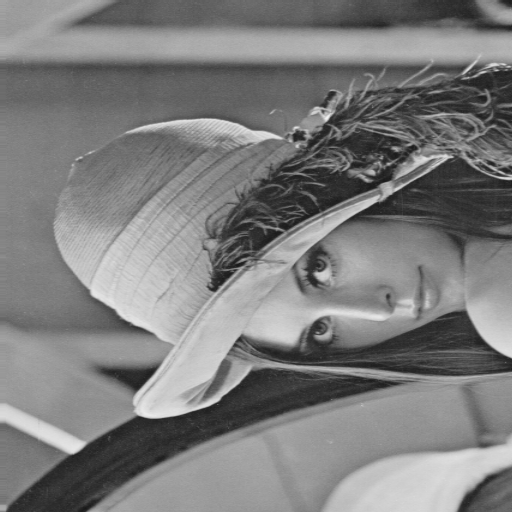

In [34]:
I.open('lena_bilinear.pgm')

Factor=4

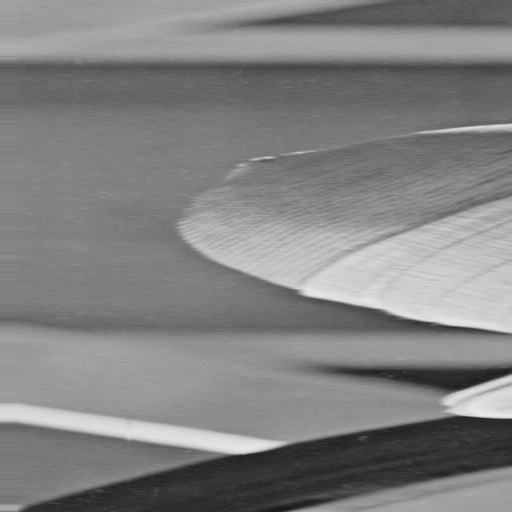

In [143]:
I.open('lena_bilinear.pgm')

## Гауссов фильтр

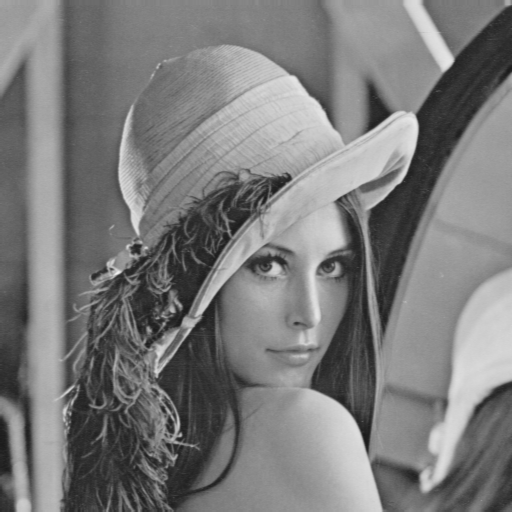

In [41]:
I.open('lena_gauss.pgm')

## Билатеральный фильтр c разными параметрами
Bilateral_Kernel<<<grid, block>>>(d_result_pixels, 3, 200, 0, WIDTH, HEIGHT);

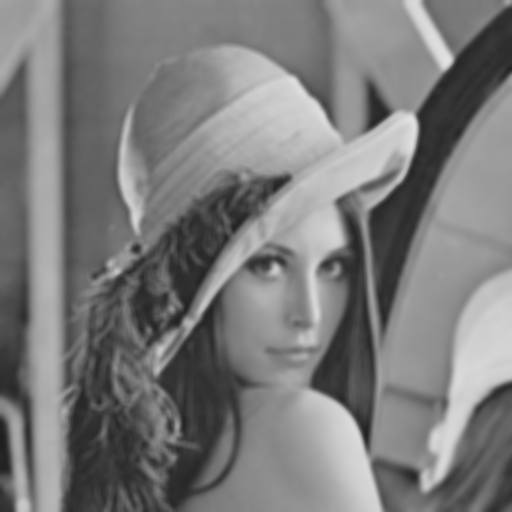

In [145]:
I.open('lena_bilateral.pgm')

Bilateral_Kernel<<<grid, block>>>(d_result_pixels, 3, 200, 0, WIDTH, HEIGHT);

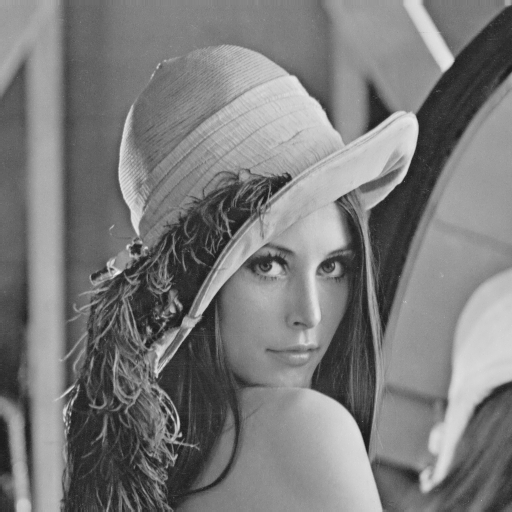

In [146]:
I.open('lena_bilateral.pgm')

# Фильтр Ланцоша c разными параметрами
Lanczos_Kernel<<<grid, block>>> (d_result_pixels, 2, 1, 10, 1, 1, WIDTH, HEIGHT);

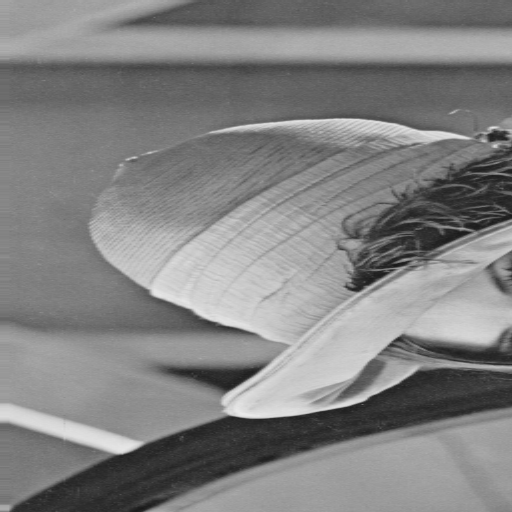

In [147]:
I.open('lena_lancroz.pgm')

 Lanczos_Kernel<<<grid, block>>> (d_result_pixels, 1.1, 4, 10, 2, 2, WIDTH, HEIGHT);

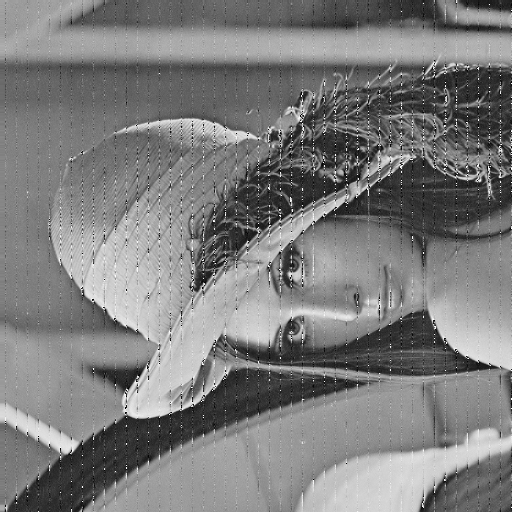

In [149]:
I.open('lena_lancroz.pgm')

# Поиск оптимального размера блока 

Размер блока 8

In [155]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.267872
Bilateral GPU elapsed time: 0.758944


Размер блока 16

Размер блока 16

In [156]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.231392
Bilateral GPU elapsed time: 0.787552


Размер блока 32

In [157]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.217792
Bilateral GPU elapsed time: 0.861824


Размер блока 48

In [162]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.160384
Bilateral GPU elapsed time: 0.119104


Размер блока 64

In [164]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.11856
Bilateral GPU elapsed time: 0.138944


Размер блока 128

In [159]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.143936
Bilateral GPU elapsed time: 0.126016


Размер блока 256

In [160]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.113312
Bilateral GPU elapsed time: 0.120352


Размер блока 512

In [161]:
! ../cmake-build-debug/lab6

Texture was successfully binded
Negative GPU elapsed time: 0.122176
Bilateral GPU elapsed time: 0.1032


**Вывод** Оптимальный размер блока равен 48, дальнейший рост производительности замедляется. Основным фактором ограничивающим производительность в данном случае является шина памяти. Данный размер блока позволяет занять все потоковые процессоры устройства, и при этом адресует не слишком большую область изображения.  